In [1]:
%cd drive/MyDrive/Colab Notebooks/big data sample

/content/drive/MyDrive/Colab Notebooks/big data sample


In [48]:
import matplotlib as mpl
import matplotlib.font_manager as fm

###選擇下載翰字鑄造的台北黑體
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
###也可以從文件夾符號中的最左邊上傳其他中文字型

###加入到matplotlib的字型家族中
fm.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2022-12-01 14:09:28--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 108.177.125.113, 108.177.125.138, 108.177.125.101, ...
Connecting to drive.google.com (drive.google.com)|108.177.125.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/84n0e9i5nttj3i568upbq2kdoh6vfe0h/1669903725000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=677bf6fb-78d5-4b65-881b-4d88a29923b1 [following]
--2022-12-01 14:09:31--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/84n0e9i5nttj3i568upbq2kdoh6vfe0h/1669903725000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=677bf6fb-78d5-4b65-881b-4d88a29923b1
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 142.251.8.132, 2404:6800:4008:c15::84
Connecting to doc

In [61]:
import os
import json
import requests
import math
import re
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from pandas.core.frame import DataFrame

# 從1111網站抓取相關職位的訊息

In [42]:
baseurl = 'https://www.1111.com.tw/search/job?ks=AI&page='

html = requests.get(baseurl + '1')
###'lxml'和'html.parser'功能相近，但'lxml'分析網頁較快
soup = BeautifulSoup(html.text, 'lxml')
tem = soup.find('div', {'class':'srh-result-count nav_item job_count'})
print(tem)

total = int(tem.get('data-count').replace(',',''))
print('共找到{}筆資料'.format(total))

<div aria-label="筆資料" class="srh-result-count nav_item job_count" data-condition="1" data-count="1,360"></div>
共找到1360筆資料


In [17]:
job = soup.find_all('div', {'class':'body-wrapper'})
print(len(job))
info = job[0].find('div', {'class':'job_item_info'})
info

20


<div class="job_item_info"><div class="job_item_badge_mobile_show"><div class="badge_group"></div></div><a href="https://www.1111.com.tw/job/92209106/" target="_blank"><h5 class="card-title title_6"><em>AI</em><em>人工智慧</em>演算法主管</h5></a><div class="card-subtitle mb-4 text-muted happiness-hidd"><a href="https://www.1111.com.tw/corp/582263/" target="_blank" title="《公司名稱》宇隆科技股份有限公司
《行業類別》其他金屬相關製造
《公司住址》台中市梧棲區經二路"><h6 class="job_item_company mb-1 digit_5 body_3">宇隆科技股份有限公司</h6><div class="job_item_detail d-flex body_4"><a class="job_item_detail_location mr-3 position-relative" href="/search/job?c0=100925" target="_blank" title="搜尋更多台中市梧棲區工作">台中市梧棲區</a><div class="job_item_detail_salary ml-3 font-weight-style digit_6">面議（經常性薪資4萬/月含以上）</div></div></a></div><div class="job_item_data_mobile_show"><div class="job_item_data"><div class="applicants mb-3 d-flex align-items-center"><span>應徵人數：</span><span class="applicants_data">1-5人</span><span class="item_icon item_icon_fire UI_icon_fire4 "></spa

In [45]:
###最多只取1500筆資料
if total>1500:
  total = 1500

###看最後要取到幾頁，ceil做無條件進位  
page_num = math.ceil(total/20)  
df = []

for num in range(page_num):
    url = baseurl + str(num+1)
    html = requests.get(url)
    soup = BeautifulSoup(html.text, 'lxml')
    job = soup.find_all('div', {'class':'body-wrapper'})

    for i in range(len(job)):
      try:
        info = job[i].find('div',{'class':'job_item_info'})
        ###職位名稱
        name = info.find('h5').text
        ###職位工作內容的網址
        site = info.find('a').get('href')
        ###公司信息:(名稱，類別，工作地點)
        title = info.find('div', {'class':'card-subtitle mb-4 text-muted happiness-hidd'}).find('a').get('title')
        title_list = title.split('\n')
        
        comp_name = title_list[0].replace('《公司名稱》','')
        comp_class = title_list[1].replace('《行業類別》','')
        area = title_list[2].replace('《公司住址》','')
        ###薪資
        salary = info.find('div', {'class':'job_item_detail_salary ml-3 font-weight-style digit_6'}).text
        ###應徵人數
        person = info.find('span', {'class':'applicants_data'}).text
        ###其他事項
        others = info.find('p', {'class':'card-text job_item_description body_4'}).text

        ###把每個工作存到dataframe中
        df_one = pd.DataFrame([{'職務名稱':name,
                      '工作網址': site,
                      '公司名稱': comp_name,
                      '公司類別': comp_class,
                      '工作地點':area,
                      '薪資':salary,
                      '應徵人數':person,
                      '其他事項':others }],
                      )

        df.append(df_one)
      except:
        pass
    print('處理第 ' + str(num+1) + ' 頁完畢！')

df = pd.concat(df, ignore_index=True)
print(len(df.index))

處理第 1 頁完畢！
處理第 2 頁完畢！
處理第 3 頁完畢！
處理第 4 頁完畢！
處理第 5 頁完畢！
處理第 6 頁完畢！
處理第 7 頁完畢！
處理第 8 頁完畢！
處理第 9 頁完畢！
處理第 10 頁完畢！
處理第 11 頁完畢！
處理第 12 頁完畢！
處理第 13 頁完畢！
處理第 14 頁完畢！
處理第 15 頁完畢！
處理第 16 頁完畢！
處理第 17 頁完畢！
處理第 18 頁完畢！
處理第 19 頁完畢！
處理第 20 頁完畢！
處理第 21 頁完畢！
處理第 22 頁完畢！
處理第 23 頁完畢！
處理第 24 頁完畢！
處理第 25 頁完畢！
處理第 26 頁完畢！
處理第 27 頁完畢！
處理第 28 頁完畢！
處理第 29 頁完畢！
處理第 30 頁完畢！
處理第 31 頁完畢！
處理第 32 頁完畢！
處理第 33 頁完畢！
處理第 34 頁完畢！
處理第 35 頁完畢！
處理第 36 頁完畢！
處理第 37 頁完畢！
處理第 38 頁完畢！
處理第 39 頁完畢！
處理第 40 頁完畢！
處理第 41 頁完畢！
處理第 42 頁完畢！
處理第 43 頁完畢！
處理第 44 頁完畢！
處理第 45 頁完畢！
處理第 46 頁完畢！
處理第 47 頁完畢！
處理第 48 頁完畢！
處理第 49 頁完畢！
處理第 50 頁完畢！
處理第 51 頁完畢！
處理第 52 頁完畢！
處理第 53 頁完畢！
處理第 54 頁完畢！
處理第 55 頁完畢！
處理第 56 頁完畢！
處理第 57 頁完畢！
處理第 58 頁完畢！
處理第 59 頁完畢！
處理第 60 頁完畢！
處理第 61 頁完畢！
處理第 62 頁完畢！
處理第 63 頁完畢！
處理第 64 頁完畢！
處理第 65 頁完畢！
處理第 66 頁完畢！
處理第 67 頁完畢！
處理第 68 頁完畢！
1360


In [47]:
df.to_excel('1111/AI_data.xlsx', index=0) 

# 讀取抓下來的資訊檔並用圖表顯示

In [50]:
data = pd.read_excel('1111/AI_data.xlsx')
data.head(n=3)

,職務名稱,工作網址,公司名稱,公司類別,工作地點,薪資,應徵人數,其他事項
0,AI人工智慧演算法主管,https://www.1111.com.tw/job/92209106/,宇隆科技股份有限公司\r,其他金屬相關製造\r,台中市梧棲區經二路,面議（經常性薪資4萬/月含以上）,1-5人,1、負責參與公司核心AI算法設計和研發，承接公司各產品演算法工作；規劃相關算法的技術路線；\...
1,AI人工智慧軟體工程師,https://www.1111.com.tw/job/85116282/,群控系統有限公司\r,自動控制相關\r,高雄市楠梓區援中路,月薪 3.5萬~5萬元,1-5人,1.大數據分析 \n2.AI演算法開發設計運用 \n3.機器學習應用 \n4.資料庫與雲端分...
2,AI人工智慧應用專業講師,https://www.1111.com.tw/job/91285688/,社團法人新竹市職訓教育協會\r,協會╱基金會\r,"《品牌名稱》經濟部IPAS能力鑑定認同機構、多益口說測驗-新竹考場,新竹職訓、智慧機械產業專...","時薪 400~2,000元",1-5人,1.結合業界實務經驗進行個案教學，讓學生與職場接軌\n2.特定主題的專業領域，協助訓練中心課...


台北    455
新北     86
桃園     51
台中     63
台南     25
高雄     36
dtype: int64


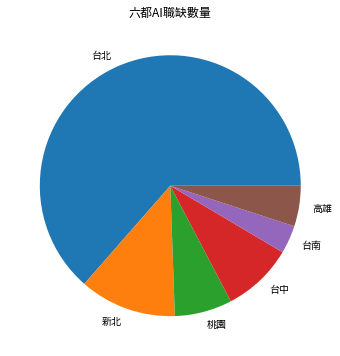

In [54]:
###六都工作職缺
city = ['台北', '新北', '桃園', '台中', '台南', '高雄']
count = []
for i in range(len(city)):
  df1 = df[df['工作地點'].str.contains(city[i])]
  count.append(len(df1))

ser = pd.Series(count, index=city)
print(ser)

###繪圖時不顯示座標軸
plt.axis('off')
ser.plot(kind='pie', title='六都AI職缺數量', figsize=(6,6))

台北    44925
新北    39145
桃園    38164
台中    37367
台南    37118
高雄    39040
dtype: int64


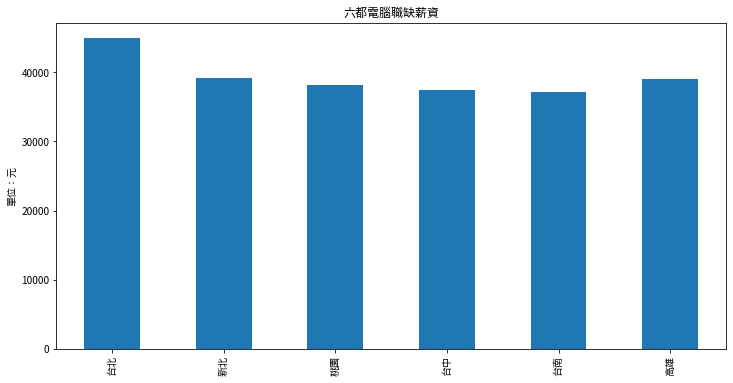

In [98]:
def transfer(strSalary):  #轉換薪資為月薪，單位為「元」
    sal = float(strSalary)
    if sal < 20:  #薪資單位為「萬」
        sal = sal * 10000
    return sal


salary_city = []
for i in range(len(city)):
  df1 = df[(df['工作地點'].str.contains(city[i])) & (df['薪資'].str.contains('月薪'))]
  ###index不是從0開始，所以要從指定的索引帶回df1找薪資
  index = df1.index
  
  total = 0
  error = 0
  for j in range(len(df1)):
    salary = df1['薪資'][index[j]].replace(',','')
    num = re.findall(r"\d+\.?\d*",salary)
    if len(num) ==1:
      true_salary = transfer(num[0])
    elif len(num) == 0:
       error += 1
       true_salary = 0
    else:
      true_salary = (transfer(num[0])+transfer(num[1]))/2
    
    total += true_salary
  
  salary_avg = int(total/ (len(df1)-error))
  salary_city.append(salary_avg)

ser = pd.Series(salary_city, index=city)  #串列轉Series
print(ser)
plt.ylabel('單位：元')
ser.plot(kind='bar', title='六都電腦職缺薪資', figsize=(12, 6))

In [113]:
df1 = df[(df['工作地點'].str.contains(city[0])) & (df['薪資'].str.contains('月薪'))]

s = df1['薪資'][1339].replace(',','')
print(s) #月薪 5萬元以上

#s = df1['薪資'][31].replace(',','')
#print(s) #月薪 32466~37132元

### + 代表數字可以出現0~無限次
### \. 找有沒有2.6萬這樣表示
### \.? 代表.可有可無
### * 代表數字可以出現0~無限次

### \d+ 一定只少要有一個數字
### \d* 不一定要有數字
#\d+\.?\d*

num = re.findall(r"\d",s)
print(num)
num1 = re.findall(r"\d+",s)
print(num1)
num2 = re.findall(r"\d+\.",s)
print(num2)
num3 = re.findall(r"\d+\.?",s)
print(num3)
num = re.findall(r"\d+\.?\d",s)
print(num)
num = re.findall(r"\d+\.?\d*",s)
print(num)

月薪 5萬元以上
['5']
['5']
[]
['5']
[]
['5']
